# 🌠 Preliminary Data Visualization

## 👽 Load and Summarize

In [71]:
# Required libraries
# import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# !pip install --upgrade pandas
import pandas as pd
# print(pd.__version__) # I am having trouble with pandas and dataframes...
import seaborn as sns
# print(sns.__version__)  # Should be 0.11.0 or higher so that `histplot() works
# !pip install --upgrade seaborn
from sklearn.feature_selection import VarianceThreshold

# Load the data
data = pd.read_csv('./data/train_data.csv')

print(data.shape)
data.describe()

(25192, 42)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,...,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,...,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,...,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,...,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,...,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,...,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 🧯 Suppress the `FutureWarning`

In [72]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

## 🧼 Clean the Dataset

In [73]:
# # Convert all object columns to strings
cols = ['protocol_type', 'service', 'flag', 'class']

data[cols] = data[cols].astype(str)

data = data.dropna()

# print((data['is_host_login'] == 1).count()) # 25192 empty, so I will drop
# Drop `is_host_login`

# Search for bad columns
constant_cols = [col for col in data.columns if data[col].nunique(dropna=False) == 1]
# print("Useless columns:", constant_cols)  Useless columns: ['num_outbound_cmds', 'is_host_login']
# "Let it all drop" - Modest Mouse
data = data.drop(columns=constant_cols)

# print(data.dtypes)

# Convert the label column
data['class'] = data['class'].map({'normal': 0, 'anomaly': 1})


# Get the binary columns for logistic regression
binary_cols = []

# Get the numeric clumns
numeric_cols = data.select_dtypes(include='number').columns

for col in data.select_dtypes(include='number').columns:
    unique_vals = sorted(data[col].dropna().unique())
    if unique_vals == [0, 1]:
        binary_cols.append(col)

# print("Binary columns:", binary_cols)
binary_cols.remove('num_shells')
# print(binary_cols)
# Separate the numeric and binary columns

numeric_cols = [col for col in numeric_cols if col not in binary_cols]

## Investigating Low Variance Cells

In [77]:
# Fit the selector
selector = VarianceThreshold(threshold=0.001)
selector.fit(data[numeric_cols])  # call .fit() before accessing .variances_

# Now safe to access .variances_
low_variance = [col for col, var in zip(numeric_cols, selector.variances_) if var < 0.00001]

print("Low-variance features:\n" + "-" * 100)
print(low_variance)

if low_variance:
    print("-" * 100)
    print(data[low_variance].describe())
    print("-" * 100)
    print(data.groupby('class')[low_variance].mean())
else:
    print("No low-variance features found.")

Low-variance features:
----------------------------------------------------------------------------------------------------
[]
No low-variance features found.


In [ ]:
# Drop these rows because they don't help
# data = data.drop(columns=low_variance) # I am going to keep them for the moment

## 🦉 Class Balance

In [ ]:
sns.countplot(x='class', data=data)
plt.title("Class Distribution (Normal vs Anomaly)")

## 🔥 Correlation Matrix

In [ ]:
sns.heatmap(data[numeric_cols + ['class']].corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

In [ ]:
sns.heatmap(data[binary_cols].corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap")
plt.show()

## 📈 Numeric Distributions by Class

C:\Users\carna\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  # Remove the CWD from sys.path while we load stuff.
C:\Users\carna\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  # Remove the CWD from sys.path while we load stuff.


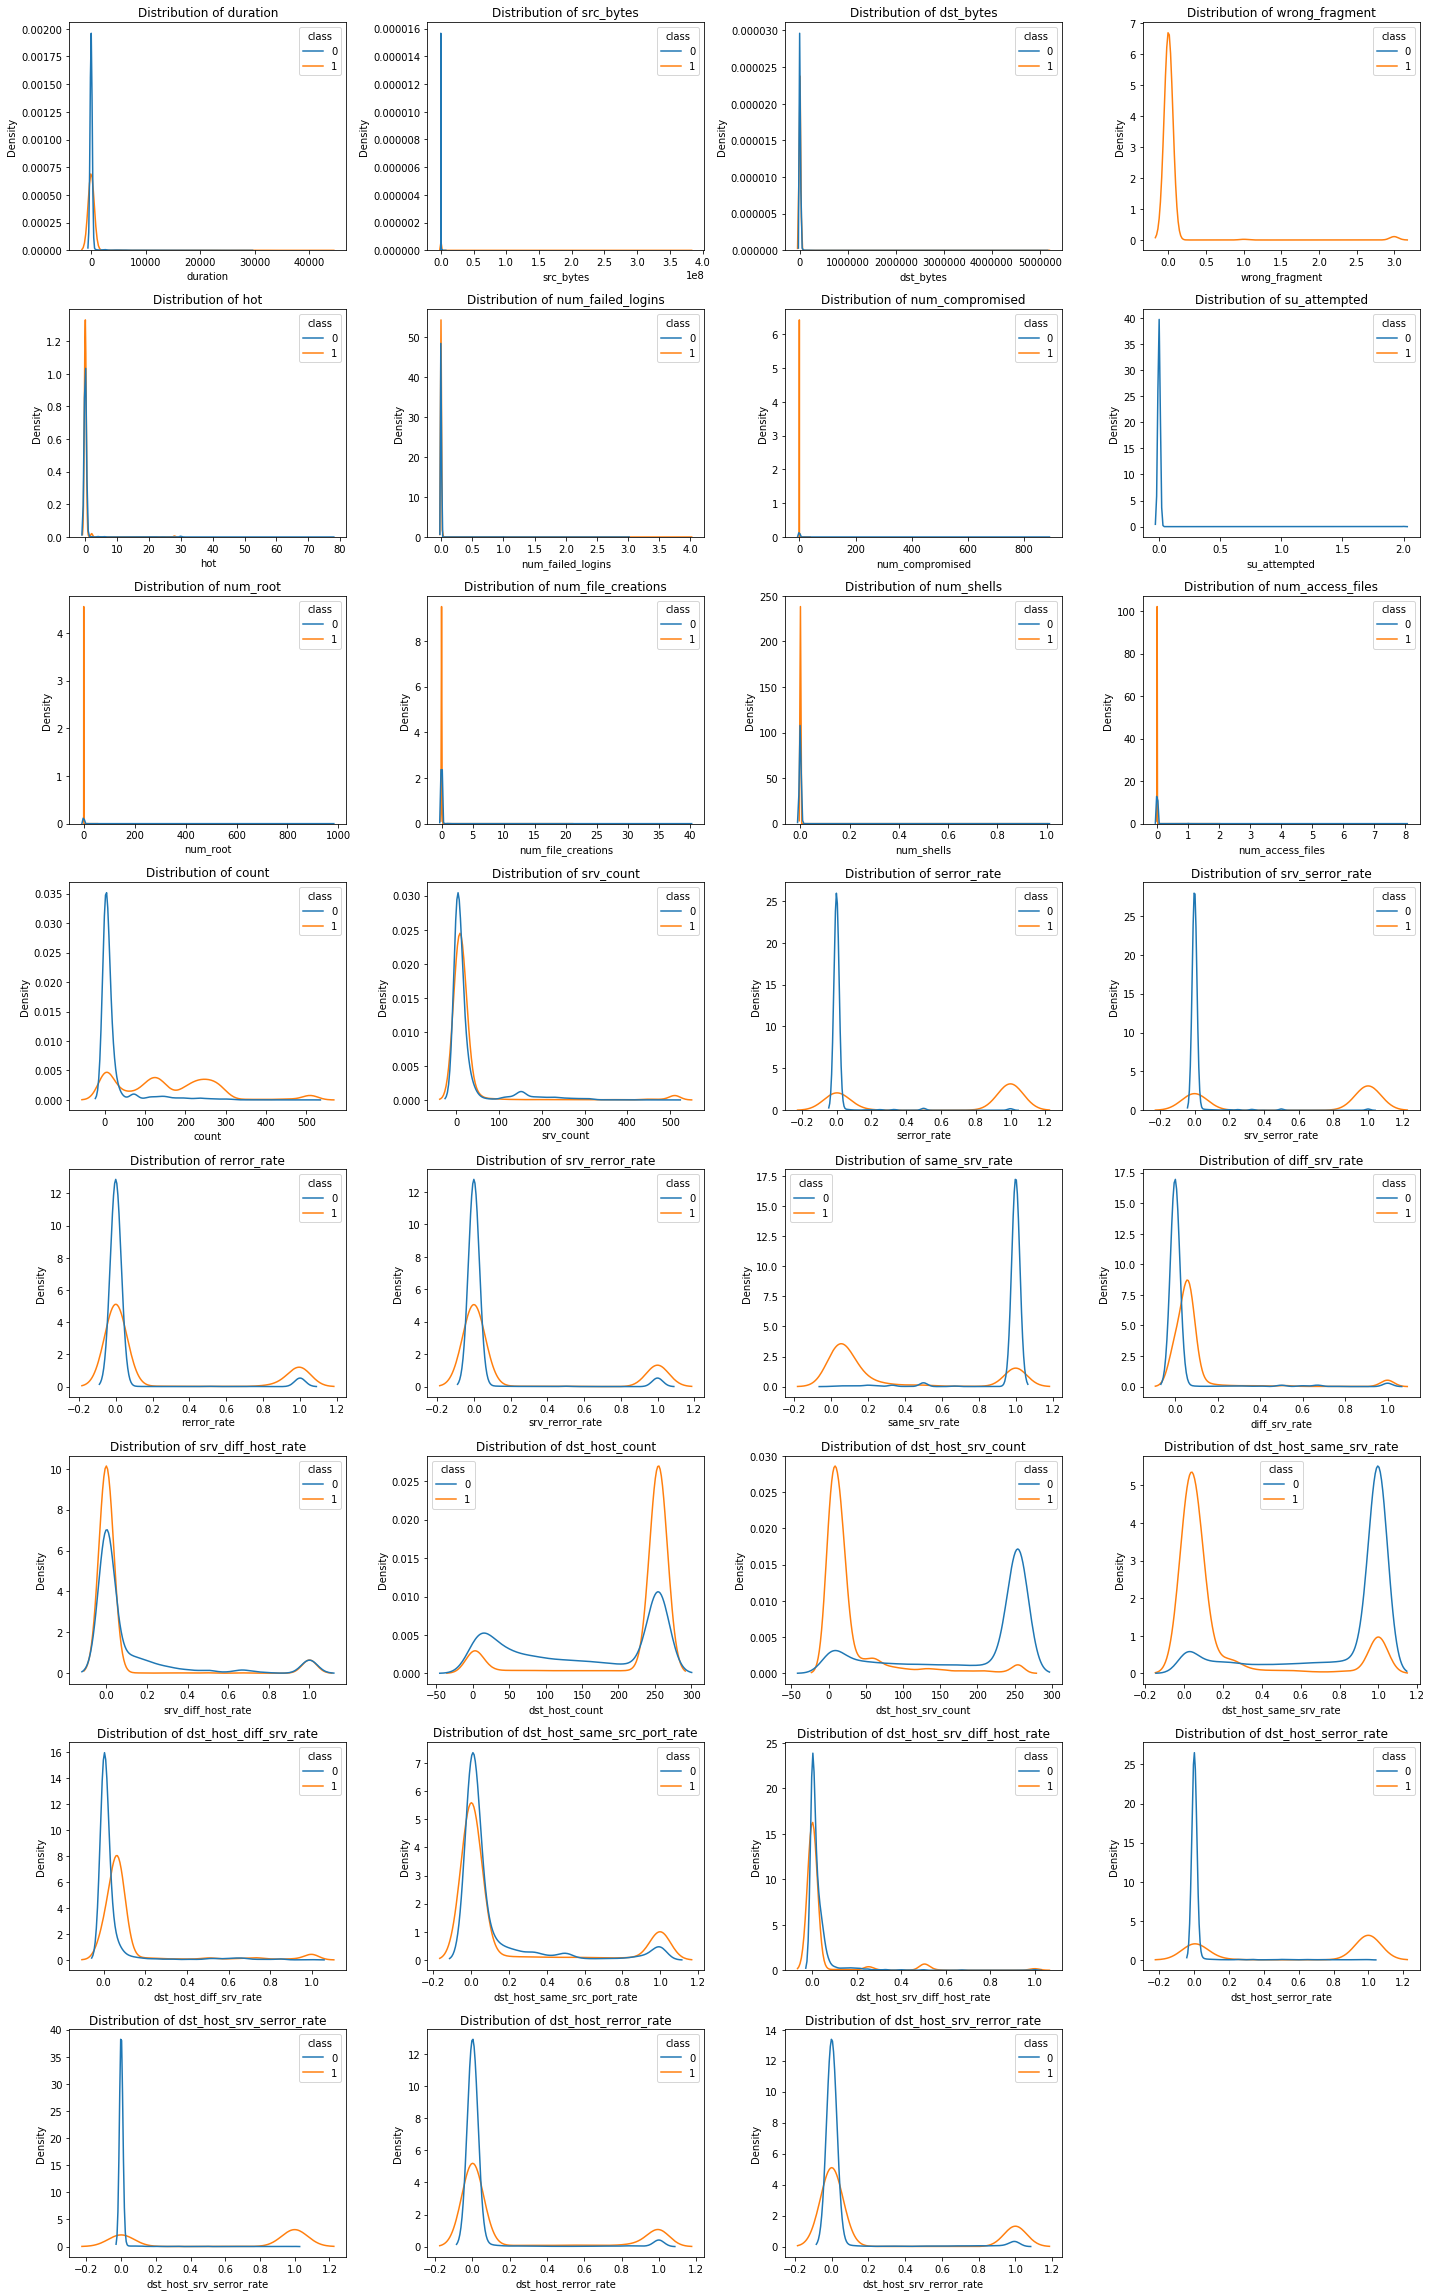

In [98]:
# Setup grid size
n_cols = 4
n_rows = int(np.ceil(len(numeric_cols) / n_cols))

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten()

# Loop through each column and plot
for i, col in enumerate(numeric_cols):
    sns.kdeplot(data=data, x=col, hue='class', common_norm=False, ax=axes[i], color='coolwarm')
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Density')

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## 🥠 Protocol by Class

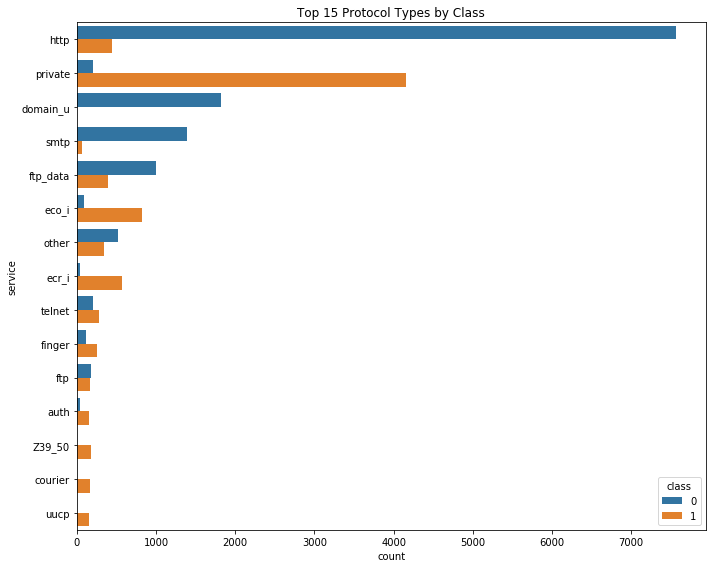

In [97]:
top_n = 15

svc_counts = data['service'].value_counts()
top_services = svc_counts.index[:top_n]
filtered_data = data[data['service'].isin(top_services)]

plt.figure(figsize=(10,8))
sns.countplot(data=filtered_data, y='service', hue='class', order=top_services)
plt.title(f"Top {top_n} Protocol Types by Class")
plt.tight_layout()
plt.show()

## 🕸 Radar Plot of the Features

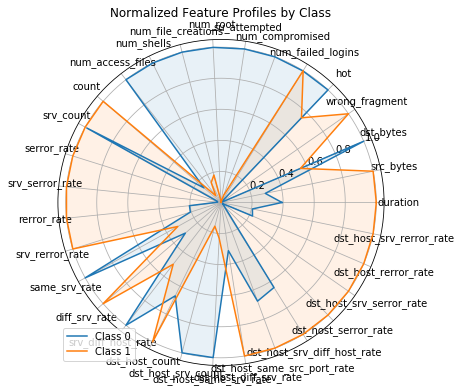

In [106]:
avg_features = data.groupby('class')[numeric_cols].mean()

avg_features = avg_features / avg_features.max()  # normalize for plot
# That does make the axes less meaningful, but hey... It's a visual.


labels = numeric_cols  # keep it small
angles = np.linspace(0, 2*np.pi, len(labels), endpoint=False).tolist()
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

for cls in avg_features.index:
    values = avg_features.loc[cls, labels].tolist()
    values += values[:1]
    ax.plot(angles, values, label=f'Class {cls}')
    ax.fill(angles, values, alpha=0.1)

ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels)
plt.legend()
plt.title("Normalized Feature Profiles by Class")
plt.show()

## 🗺 t-SNE Scatter Plots

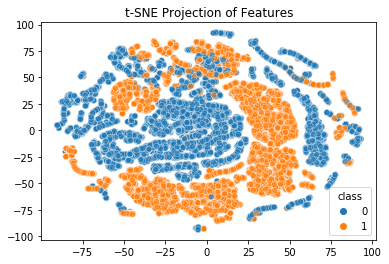

In [107]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, random_state=42069) # Nice
X_proj = tsne.fit_transform(data[numeric_cols])

sns.scatterplot(x=X_proj[:,0], y=X_proj[:,1], hue=data['class'], alpha=0.6)
plt.title("t-SNE Projection of Features")
plt.show()

In [108]:
# Save the t-SNE data

data_tsne = data.copy()
data_tsne['tsne_x'] = X_proj[:,0]
data_tsne['tsne_y'] = X_proj[:,1]

## 🚩 Check for Overlapping Points with K-Nearest Neighbours

In [112]:
from sklearn.neighbors import NearestNeighbors

X_embedded = data_tsne[['tsne_x', 'tsne_y']].values
knn = NearestNeighbors(n_neighbors=10).fit(X_embedded)
neighbors = knn.kneighbors(return_distance=False)

# Check how mixed the neighborhood is
overlap_flags = []
for i, inds in enumerate(neighbors):
    labels = data_tsne.iloc[inds]['class']
    purity = labels.value_counts(normalize=True).max()
    overlap_flags.append(purity < 0.8)  # low purity = likely overlap

data_tsne['overlap'] = overlap_flags
overlapping_samples = data_tsne[data_tsne['overlap']]


overlapping_samples.describe()
# [697 rows x 43 columns]
# So maybe I should train on these rows?

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class,tsne_x,tsne_y
count,697.000000,697.000000,6.970000e+02,697.000000,697.000000,697.0,697.000000,697.000000,697.000000,697.000000,...,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000,697.000000
mean,1833.436155,605.307030,5.196894e+04,0.002869,0.131994,0.0,0.057389,0.004304,0.143472,0.011478,...,0.216729,0.578651,0.080158,0.088264,0.063013,0.195710,0.183343,0.493544,23.793756,43.608452
std,4127.037194,3305.466824,5.133477e+05,0.053529,0.582129,0.0,0.835375,0.065512,0.350805,0.214115,...,0.310641,0.427874,0.201157,0.265596,0.222475,0.376509,0.383409,0.500317,43.392986,24.558315
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-83.949707,-83.695747
25%,0.000000,1.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.090000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-9.599023,33.577766
50%,0.000000,30.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.040000,0.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.551726,49.748444
75%,0.000000,246.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,...,0.500000,1.000000,0.030000,0.000000,0.000000,0.000000,0.000000,1.000000,62.680073,57.523693
max,17419.000000,44788.000000,5.151385e+06,1.000000,3.000000,0.0,20.000000,1.000000,1.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,90.082428,78.094360
